In [44]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
from operator import itemgetter
import datetime

### This analyses is done on a network by removing the anomalous paper that creates at least 1877 degree to the participants, paper_id "1vimqhdp"

That [anomalous paper](https://ccforum.biomedcentral.com/articles/10.1186/s13054-016-1208-6) was just actually a list of participants of a symposium titled "36th International Symposium on Intensive Care and Emergency Medicine: Brussels, Belgium. 15-18 March 2016". Because each participant is connected by a link, each of the participatns in that symposium had a degree as high as 1877 (the number of participants in tha symposium), which is unintended for our analysis. 

In [2]:
with open("../outputs/untracked/00_01_02_node_id_to_first_publish_date.pickle", "rb") as f:
    node_id_to_first_publish_date = pickle.load(f)

In [3]:
with open("../outputs/untracked/00_01_02_node_id_to_node_name.json", "r") as f:
    node_id_to_node_name = json.load(f)

Reading the edgelist of the co-authorship network we built with script 00_01_01_create_network_of_authors.py

In [4]:
with open("../outputs/untracked/00_01_02_coauthorship_network.edgelist", "r") as f:
    G = nx.read_weighted_edgelist(f)

In [5]:
# %%
## First plot the degree distribution
def get_binned_distribution(values, number_of_bins = 20, log_binning = False, base = 10):
    lower_bound = min(values)
    upper_bound = max(values)
    
    if log_binning:
        lower_bound = np.log10(lower_bound)/ np.log10(base) if lower_bound > 0 else -1
        upper_bound = np.log10(upper_bound)/ np.log10(base)
        bins = np.logspace(lower_bound, upper_bound, number_of_bins, base=base)
    else:
        bins = np.linspace(lower_bound, upper_bound, number_of_bins)
    
    ## Calculating histogram
    y, _ = np.histogram(values, bins = bins, density = True)
    
    ## Now for each y we need to compute the value of x
    x = bins[1:] - np.diff(bins) / 2.
    
    # sanity check for probability density
    #print sum(map(lambda a,b : a*b, [bins[i] - bins[i-1] for i in xrange(1,len(bins))],y))
    
    return x,y

def plot(x,y, log = True, xsize = 8, ysize = 3, xlabel="", ylabel=""):
    plotted_figure = plt.figure(figsize = (xsize,ysize))
    if log:
        plt.loglog(x,y, '.')
    else:
        plt.plot(x,y, '.')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return plotted_figure

#### First the number of nodes

In [6]:
N = G.number_of_nodes()
print(N)

43004


#### Number of edges

In [7]:
E = G.number_of_edges()
print(E)

367465


#### Density

In [8]:
D = E/(N*(N-1)/2.)
print(D)

0.0003974096132706815


### Largest degree nodes

Top 20 high degree nodes

In [23]:
[(node_id,node_id_to_node_name[node_id],deg) for node_id,deg in sorted(G.degree(),key = lambda x:x[1], reverse = True)][:30]

[('6421', 'christian drosten', 745),
 ('42018', 'yan li', 712),
 ('31627', 'ralph s baric', 564),
 ('36635', 'suxiang tong', 531),
 ('21566', 'kwokyung yuen', 524),
 ('41054', 'xiaoyan lu', 517),
 ('18043', 'jing wang', 445),
 ('3309', 'azaibi tamin', 416),
 ('35985', 'stanley perlman', 407),
 ('36166', 'stephen lindstrom', 396),
 ('22948', 'lindsay kim', 396),
 ('36558', 'susan i gerber', 391),
 ('4486', 'brian rha', 391),
 ('4440', 'brett whitaker', 387),
 ('34902', 'shifaq kamili', 381),
 ('24798', 'marcel a muller', 379),
 ('3701', 'bart l haagmans', 377),
 ('18058', 'jing zhang', 372),
 ('16587', 'janna murray', 367),
 ('22760', 'lijuan wang', 367),
 ('4473', 'brian lynch', 367),
 ('39519', 'wei zhang', 366),
 ('26085', 'megan wallace', 366),
 ('42812', 'ying tao', 364),
 ('18488', 'joana lively', 350),
 ('20906', 'kevin chathamstephens', 350),
 ('21956', 'lakshmi malapati', 350),
 ('24680', 'manisha patel', 350),
 ('28718', 'nora chea', 349),
 ('39065', 'volker thiel', 342)]

We can see that we have recovered some important names in the literature.

Average degree

In [12]:
print("Average degree", sum(dict(G.degree()).values())/float(G.number_of_nodes()))

Average degree 17.089805599479117


Degree distribution

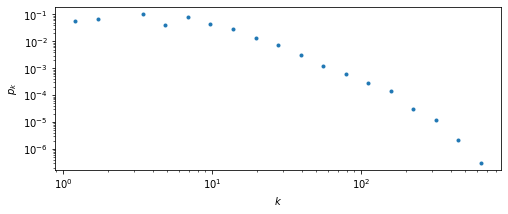

In [13]:
x,y = get_binned_distribution(list(dict(G.degree()).values()), log_binning=True)
_ = plot(x,y, xlabel=r"$k$", ylabel=r"$p_{k}$")

### Lets check if the network is connected or not

In [14]:
if nx.is_connected(G):
    print("The network is connected")
else:
    print("The network is not connected")

The network is not connected


### Component sizes plot

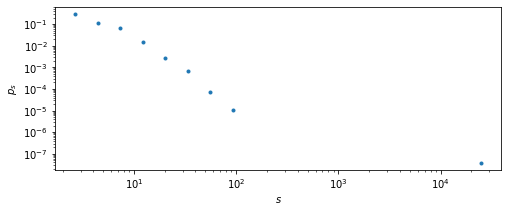

In [29]:
x,y = get_binned_distribution(list(map(len, nx.connected_components(G))), log_binning=True)
_ = plot(x,y, xlabel=r"$s$", ylabel=r"$p_{s}$")

### Getting into the giant component

Getting the nodes in the giant component

In [34]:
gcc_nodes = sorted(nx.connected_components(G),key = len, reverse=True)[0]

Now getting the induced subgraph in the giant component

In [36]:
gcc = nx.subgraph(G,gcc_nodes)

#### Portion of nodes in the connected giant components

In [49]:
print(sorted([len(x) for x in nx.connected_components(G)],reverse = True)[0] / G.number_of_nodes())

0.7234908380615757


### Pagerank for the nodes inside giant component

In [38]:
pr_gcc = nx.pagerank(gcc)

#### Top 20 high pagerank nodes in the giant component

In [43]:
[(node_id,node_id_to_node_name[node_id],deg) for node_id,deg in sorted(pr_gcc.items(),key = itemgetter(1), reverse= True)[:20]]

[('6421', 'christian drosten', 0.0011737812320709651),
 ('31627', 'ralph s baric', 0.0009538775183508149),
 ('21566', 'kwokyung yuen', 0.0009030539001520056),
 ('35985', 'stanley perlman', 0.0007994833753705915),
 ('42018', 'yan li', 0.0007458736520408899),
 ('23611', 'luis enjuanes', 0.0006824644043780092),
 ('3701', 'bart l haagmans', 0.0006609249973752471),
 ('39065', 'volker thiel', 0.0005817935920803719),
 ('34888', 'shibo jiang', 0.0005699006191727787),
 ('24798', 'marcel a muller', 0.0005554939727607863),
 ('10108', 'eric j snijder', 0.0005454395509219103),
 ('36578', 'susan r weiss', 0.0005185992311019467),
 ('45164', 'ziad a memish', 0.0004980451944560327),
 ('44691', 'zhengli shi', 0.00047912930966261056),
 ('21561', 'kwokhung chan', 0.000477885695521154),
 ('39503', 'wei wang', 0.00047139271076657966),
 ('22955', 'linfa wang', 0.000460855345614719),
 ('24605', 'malik peiris', 0.00045212256676553246),
 ('39519', 'wei zhang', 0.00044063635405487315),
 ('36539', 'susan c baker'

### What proportion of the nodes that made their first publication after January 31, 2020 are part of the giant component?

First lets explore how many nodes first published after February 1, 2020

In [47]:
nodes_publishing_from_feb_2020 = [node_id for node_id, date in node_id_to_first_publish_date.items() if date > datetime.datetime(2020,1,31)]
print(len(nodes_publishing_from_feb_2020))

12207


Portion of nodes that are in the giant component

In [48]:
len([node for node in nodes_publishing_from_feb_2020 if node in gcc_nodes])/len(nodes_publishing_from_feb_2020)

0.6587204063242402

So total 65% of the nodes who published after January 31, 2020 are in the giant component.